In [1]:
import pandas as pd
import numpy as np
import os
import pickle
from tqdm.notebook import tqdm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tqdm import tqdm
from PIL import Image

In [2]:
# Load InceptionV3 model, excluding the top layer
model = InceptionV3(include_top=False, pooling='avg')
print(model.summary())

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, None,      │        864 │ input_layer[0][0] │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, None,      │         96 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, None,      │      9,216 │ activation[0][0]  │
│                     │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │         96 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 32)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, None,      │     18,432 │ activation_1[0][… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        192 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, None,      │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, None,      │      5,120 │ max_pooling2d[0]… │
│                     │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        240 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, None,      │          0 │ batch_normalizat… │
│ (Activation)        │ None, 80)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, None,      │    138,240 │ activation_3[0][… │
│                     │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None,      │        576 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ None, 192)        │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, None,      │          0 │ batch_normalizat

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

None


In [3]:
# Extract features from images using InceptionV3
features = {}
directory = os.path.join("/kaggle/input/flickr-8k-images-with-captions", 'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path = os.path.join(directory, img_name)
    image = load_img(img_path, target_size=(299, 299))  # Target size specific to InceptionV3
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)  # Preprocess the image for InceptionV3
    feature = model.predict(image, verbose=0)
    image_id = img_name.split('.')[0]
    features[image_id] = feature

100%|██████████| 8091/8091 [11:16<00:00, 11.96it/s]


In [4]:
# Save extracted features to a pickle file
pickle.dump(features, open(os.path.join("/kaggle/working/", 'features_inception.pkl'), 'wb'))

In [5]:
# Load captions and features (captions remain the same as in your original code)
with open(os.path.join("/kaggle/working/", 'features_inception.pkl'), 'rb') as f:
    features = pickle.load(f)

In [6]:
with open(os.path.join("/kaggle/input/flickr-8k-images-with-captions", 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [7]:
# Create a mapping of image IDs to their captions 
mapping = {}
for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(",")
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    mapping[image_id].append(caption)

100%|██████████| 40456/40456 [00:00<00:00, 384372.64it/s]


In [8]:
# Save the mapping dictionary to a .pkl file
with open('/kaggle/working/mapping_inception.pkl', 'wb') as file:
    pickle.dump(mapping, file)

In [9]:
len(mapping)

8091

In [10]:
# Clean captions 
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            caption = caption.lower()
            caption = caption.replace('[^A-Za-z]', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word) > 1]) + ' endseq'
            captions[i] = caption

In [11]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
# preprocess the text
clean(mapping)

In [13]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [14]:
# Tokenize captions 
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

40455

In [16]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [17]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
# Save the tokenizer
with open('/kaggle/working/tokenizer_inception.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

In [19]:
# Load the tokenizer
with open('/kaggle/working/tokenizer_inception.pkl', 'rb') as file:
    tokenizer = pickle.load(file)

In [20]:
vocab_size

8485

In [21]:
# Determine the maximum length of captions
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [22]:
# Split data into train and test sets
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [23]:
# Data generator function 
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield (X1, X2), y
                X1, X2, y = list(), list(), list()
                n = 0

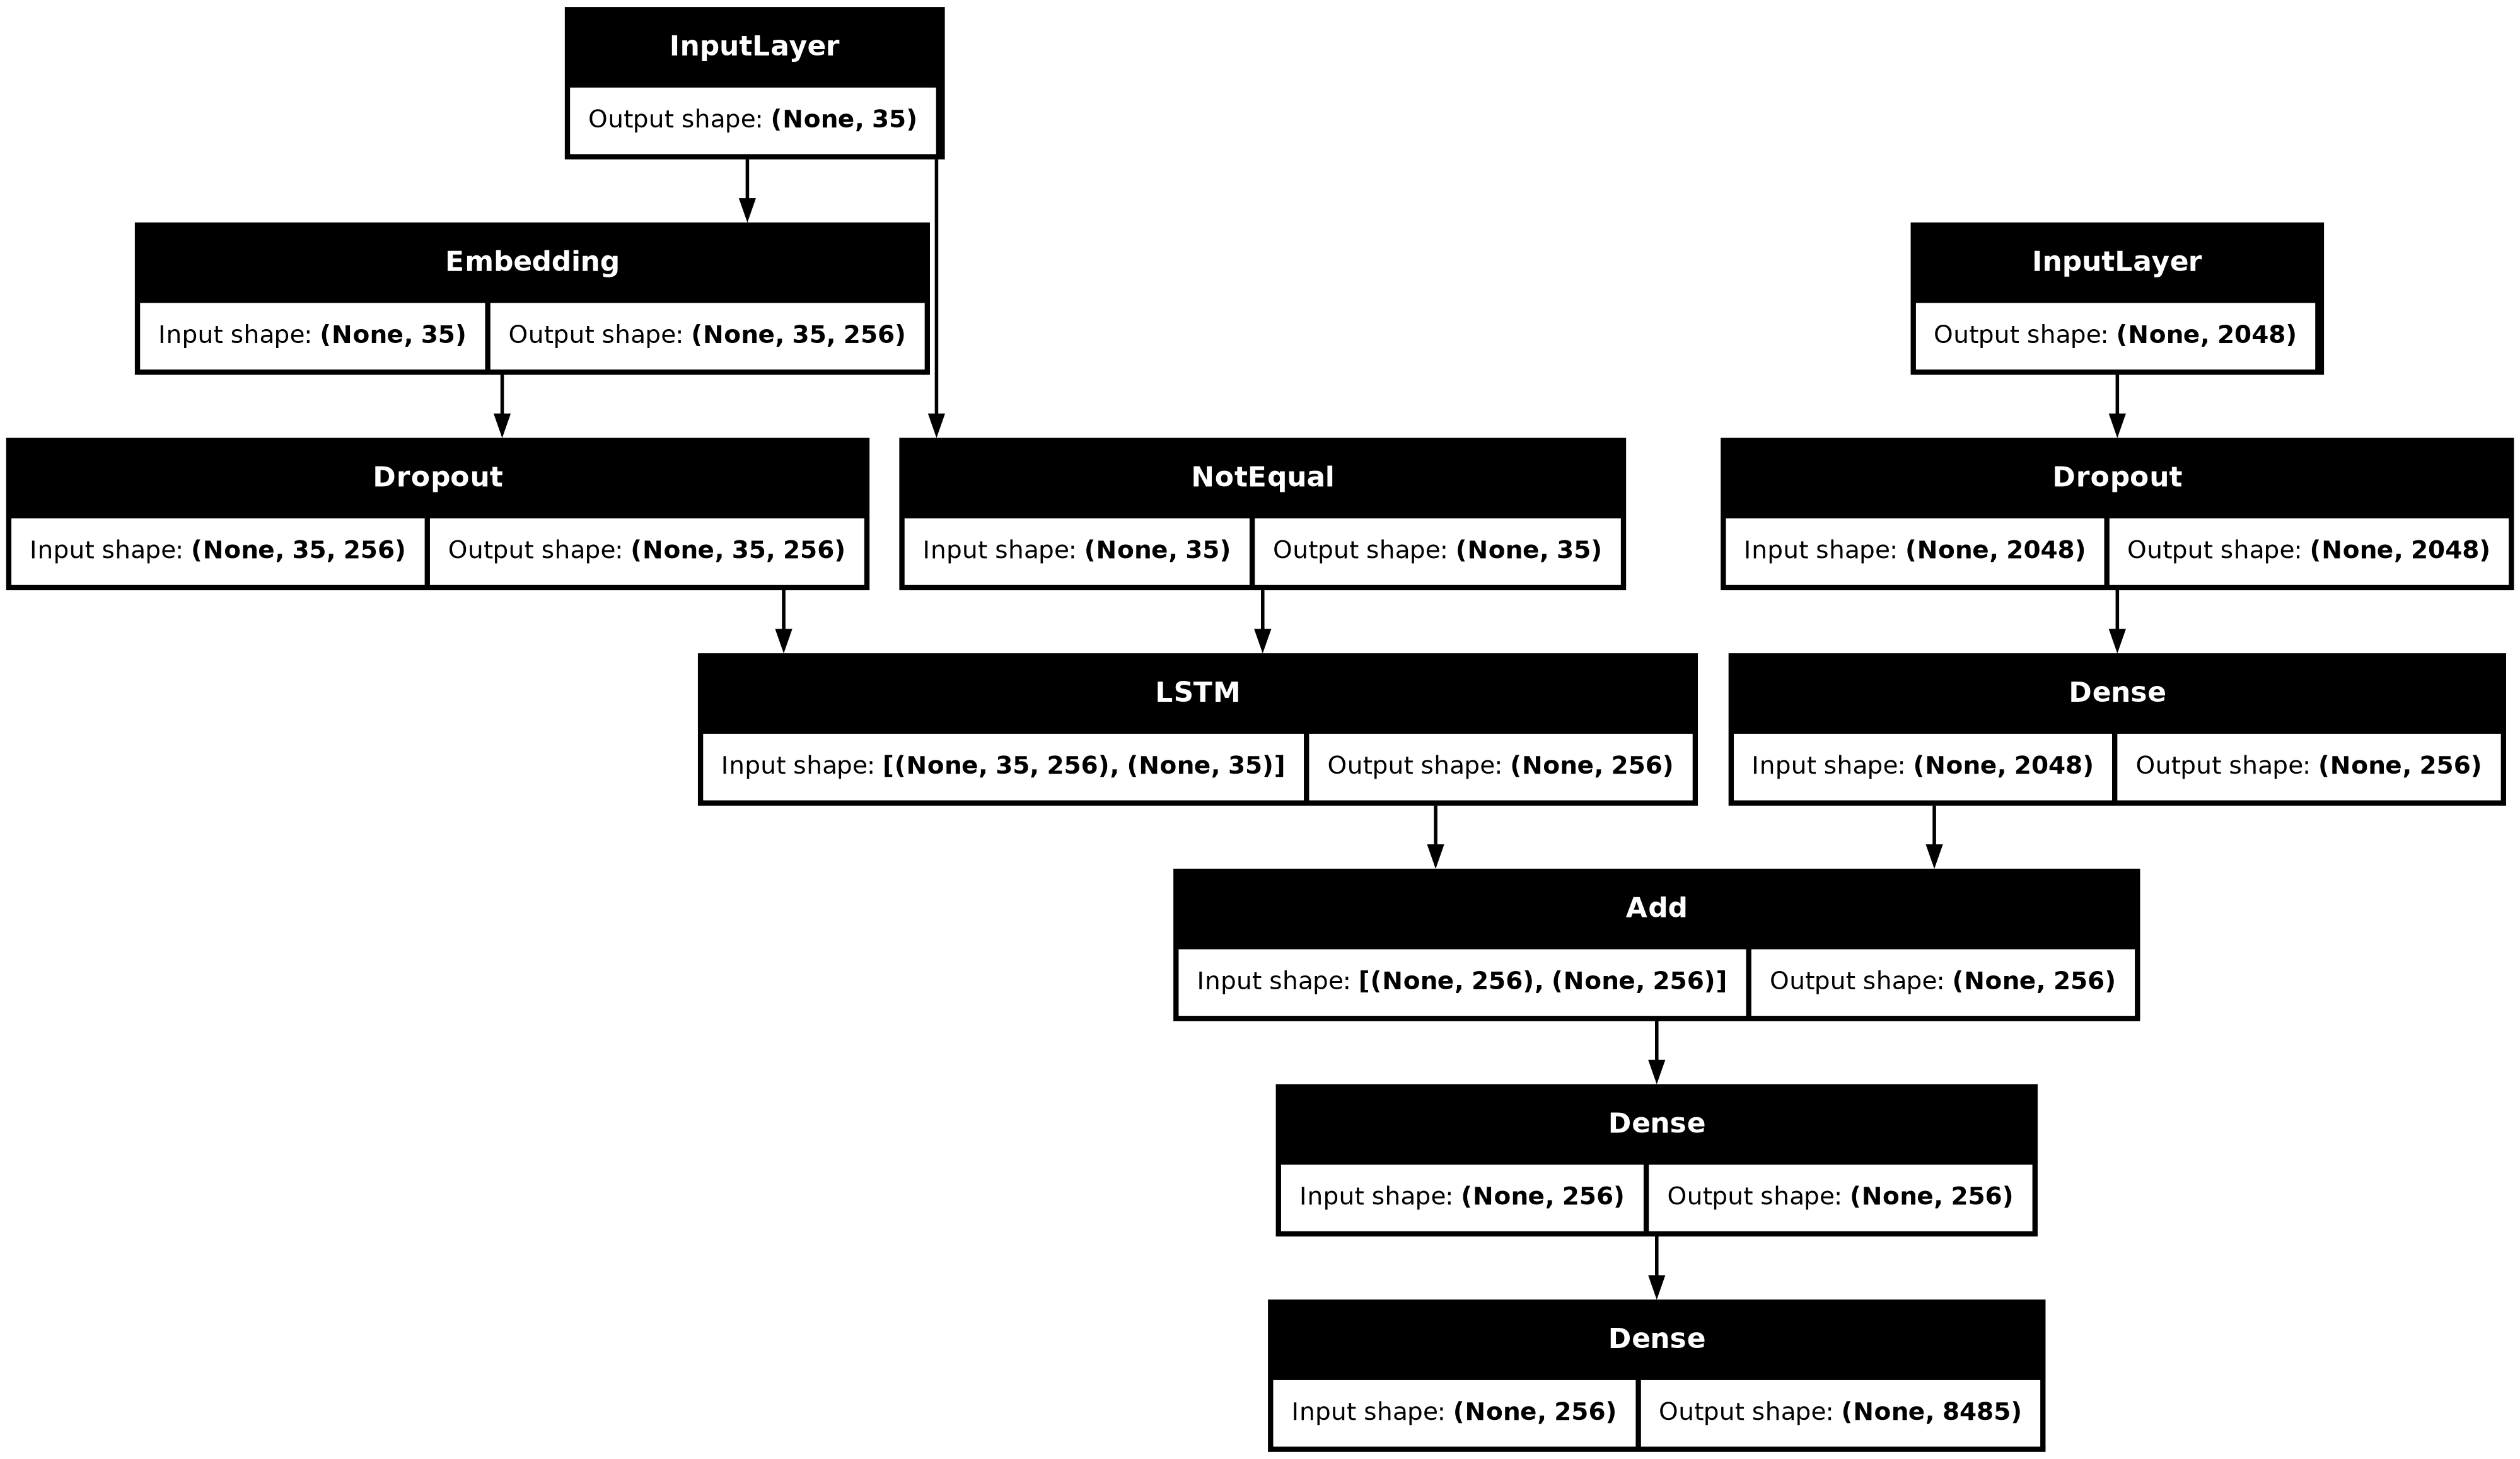

In [24]:
# Define the model architecture 
inputs1 = Input(shape=(2048,))  # InceptionV3 outputs 2048 features
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256, use_cudnn=False)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [25]:
# Train the model
epochs = 20
batch_size = 64
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

113/113 ━━━━━━━━━━━━━━━━━━━━ 411s 4s/step - loss: 6.3259
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 462ms/step - loss: 4.5876
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 462ms/step - loss: 3.9505
113/113 ━━━━━━━━━━━━━━━━━━━━ 51s 456ms/step - loss: 3.6546
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 458ms/step - loss: 3.4571
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 460ms/step - loss: 3.3061
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 459ms/step - loss: 3.1837
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 461ms/step - loss: 3.0765
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 459ms/step - loss: 2.9946
113/113 ━━━━━━━━━━━━━━━━━━━━ 51s 455ms/step - loss: 2.9219
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 459ms/step - loss: 2.8540
113/113 ━━━━━━━━━━━━━━━━━━━━ 51s 454ms/step - loss: 2.7861
113/113 ━━━━━━━━━━━━━━━━━━━━ 51s 456ms/step - loss: 2.7313
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 457ms/step - loss: 2.6804
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 460ms/step - loss: 2.6344
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 459ms/step - loss: 2.5857
113/113 ━━━━━━━━━━━━━━━━━━━━ 52s 456ms/step - loss: 2.5436

In [26]:
# Save the model
model.save("/kaggle/working/" + '/best_model_inception.keras')

In [27]:
# Define function to generate captions 
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [36]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word == 'endseq':
            break
    # Remove 'startseq' from the beginning and 'endseq' from the end
    final_caption = in_text.replace('startseq', '').replace('endseq', '').strip()

    return final_caption

In [29]:
# Test the model and compute BLEU scores 
from nltk.translate.bleu_score import corpus_bleu

actual, predicted = list(), list()
for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)

print("BLEU-1 : %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2 : %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|██████████| 810/810 [08:07<00:00,  1.66it/s]


BLEU-1 : 0.558000
BLEU-2 : 0.341911


In [37]:
import matplotlib.pyplot as plt

def generate_caption(image_name):
    # Check if the image name is provided
    if not image_name or not isinstance(image_name, str):
        print("Error: Image name must be a non-empty string.")
        return

    # Check if the image has a valid extension
    valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif']
    if not any(image_name.lower().endswith(ext) for ext in valid_extensions):
        print("Error: Invalid image format. Supported formats are: jpg, jpeg, png, bmp, gif.")
        return

    # Generate the image path
    img_path = os.path.join("/kaggle/input/flickr-8k-images-with-captions", 'Images', image_name)

    # Check if the image file exists
    if not os.path.exists(img_path):
        print(f"Error: The file '{image_name}' does not exist at the specified path.")
        return

    try:
        # Load the image
        image = Image.open(img_path)
    except Exception as e:
        print(f"Error: Could not open the image. Details: {e}")
        return

    # Extract the image ID
    image_id = image_name.split('.')[0]

    # Check if captions are available for the image
    captions = mapping.get(image_id)
    if captions:
        print('-------------------Actual---------------------')
        for caption in captions:
            print(caption)
    else:
        print('No captions available for this image.')

    # Predict the caption
    try:
        y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
        print('----------------Predicted---------------------')
        print(y_pred)
    except Exception as e:
        print(f"Error: Failed to predict the caption. Details: {e}")
        return

    # Display the image
    plt.imshow(image)
    plt.axis('off')  # Hide axes for better visualization
    plt.show()

-------------------Actual---------------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
----------------Predicted---------------------
the little girl is sitting on the stairs


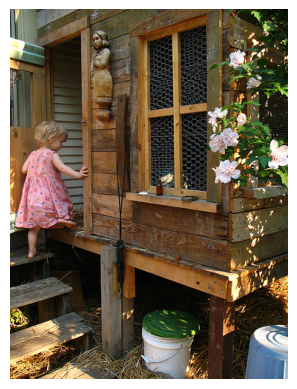

In [38]:
# Example usage
generate_caption('1000268201_693b08cb0e.jpg')

-------------------Actual---------------------
startseq boy smiles in front of stony wall in city endseq
startseq little boy is standing on the street while man in overalls is working on stone wall endseq
startseq young boy runs aross the street endseq
startseq young child is walking on stone paved street with metal pole and man behind him endseq
startseq smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him endseq
----------------Predicted---------------------
woman in black coat and black pants is walking along the steps


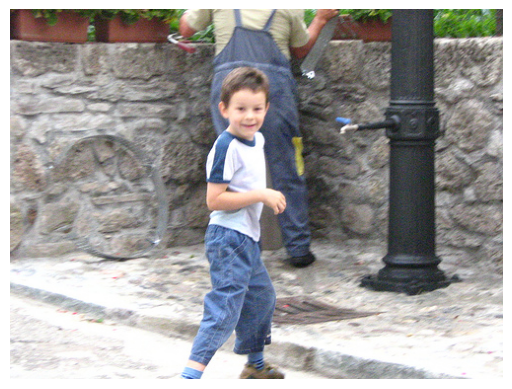

In [39]:
# Example usage
generate_caption('1015118661_980735411b.jpg')

-------------------Actual---------------------
startseq black dog and brown dog are jumping up to catch red toy endseq
startseq black dog and brown dog play with red toy on courtyard endseq
startseq brown and black lab are outside and the black lab is catching toy in its mouth endseq
startseq black dog snaps at red and black object as brown dog lunges endseq
startseq the chocolate lab jumps too late to get the toy as the black lab captures it in the driveway endseq
----------------Predicted---------------------
black dog snaps at large large object


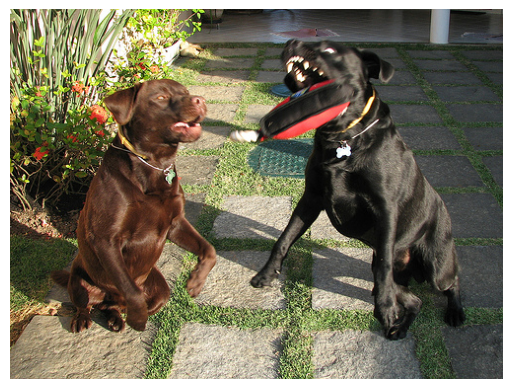

In [40]:
# Example usage
generate_caption('1030985833_b0902ea560.jpg')

-------------------Actual---------------------
startseq two constructions workers sit on beam taking break endseq
startseq two construction workers are sitting up on the side of building endseq
startseq two construction workers sitting on an i-beam endseq
startseq two construction workers take seat on steel beam endseq
startseq two men take break from construction endseq
----------------Predicted---------------------
two constructions workers are walking on the street


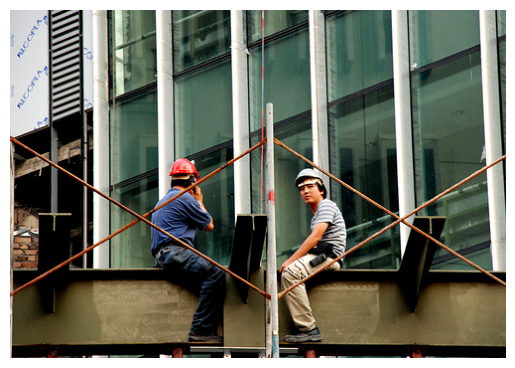

In [41]:
# Example usage
generate_caption('1055753357_4fa3d8d693.jpg')

-------------------Actual---------------------
startseq boy in blue shorts slides down slide into pool endseq
startseq boy in blue swimming trunks slides down yellow slide into wading pool with inflatable toys floating in the water endseq
startseq boy rides down slide into small backyard pool endseq
startseq boy sliding down slide into pool with colorful tubes endseq
startseq child is falling off slide onto colored balloons floating on pool of water endseq
----------------Predicted---------------------
boy slides down green slide into pool


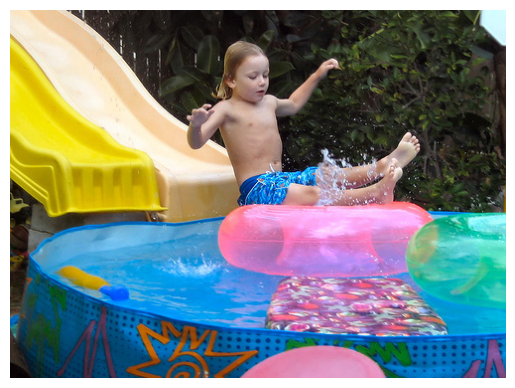

In [42]:
# Example usage
generate_caption('1077546505_a4f6c4daa9.jpg')

In [ ]:
# import matplotlib.pyplot as plt

# # Function to generate and display captions
# def generate_caption(image_name):
#     image_id = image_name.split('.')[0]
#     img_path = os.path.join("/kaggle/input/flickr-8k-images-with-captions", 'Images', image_name)
#     image = Image.open(img_path)
#     captions = mapping[image_id]
#     print('-------------------Actual---------------------')
#     for caption in captions:
#         print(caption)
#     y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
#     print('----------------Predicted---------------------')
#     print(y_pred)
#     plt.imshow(image)